[![image.png](attachment:image.png)](https://colab.research.google.com/github/davalpez/MyKaggle/blob/MyKaggle/MedicalCost/TF-LN-MedicalCost.ipynb)

# Creating a Neural Network for Classification problems

In this notebook we are going to use different machine learning techniques and neural networks to effectively learn patterns from data we have labeled with certain characteristic and so, trying to identify patterns that could be not easily visible or speeding up the classification of certain data that contains a large number of parameters.

## Defining the problem

This time, the job for our NN is to help is figure out which group does some individual element belongs to based on its own characteristics as well as the group based on the similarities that the group represents.

Let's start simple and create some data to visualize better what we can do and how can we train a model to achieve this task. I find helpful for these experiments to use some datasets that scikit provides. In this case, I will use the function [make_moons()](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html).

In [24]:
from sklearn.datasets import make_moons

n_samples = 500
seed = 30
X, y = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=seed)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=seed)


In [38]:
print(" X values: ",X[:5],", Y values :",y[:5])

 X values:  [[ 1.04504079  0.18983372]
 [-1.01867246  0.14786146]
 [ 0.23482704  1.05036349]
 [ 0.01692948  0.26916982]
 [ 0.97821768  0.19139193]] , Y values : [0 0 0 1 0]


Lets put it on a table and represent to see what kind of data are we experimenting now.

In [35]:
import pandas as pd

table_data = pd.DataFrame({"X0":X[:, 0], "X1":X[:, 1], "label":y})
table_data


,X0,X1,label
0,1.045041,0.189834,0
1,-1.018672,0.147861,0
2,0.234827,1.050363,0
3,0.016929,0.269170,1
4,0.978218,0.191392,0
...,...,...,...
495,-0.244159,1.009570,0
496,0.194925,-0.104697,1
497,1.631648,-0.282787,1
498,1.466756,-0.378222,1


In [36]:
table_data.label.value_counts()

0    250
1    250
Name: label, dtype: int64

We have two types of label and a even distribution of both of them. We can have a better view of it by plotting it:

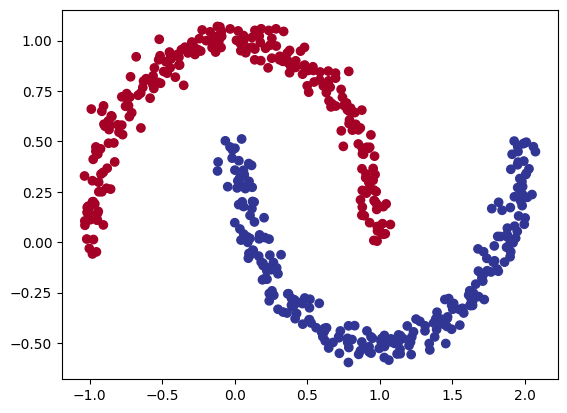

In [37]:
import matplotlib.pyplot as plt

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdYlBu);

As we only have two groups in this example, we are experimenting with a binary classification problem. We will show later on a multiclass classification problem.

## Creating the first classification model

As we went through in the other document for creating the architecture of a NN model for a regression problem, we follow the same principles for creating a NN architecture for a classification problem.

The steps if we remember are :


1.  **Create a model**, where we decide the size, number and type of the layers.

2.  **Compile the model**, where we define the loss function, we choose the optimizer and decide the metrics we use to evaluate our model.

3.  **Fit the model**, where we adjust the trainning data to our model and examinate how the model interacts and learns with that data.

We have certain aspects of our architecture we can modify and is where we can thrive to make our model more efficient and help us perform better with our tasks. To remember, these are the hyperparameters we can modify to build and enhance our NN.

**Take a look** that this time, we are specifing other characteristics speficially for our `loss function`. When in regression we use `MSE`or `MAE`, for classification we prefer to use [`Cross-entropy`](https://www.tensorflow.org/api_docs/python/tf/keras/losses/BinaryCrossentropy).

 **Hyperparameter**      | **Description**                                                                 |
|--------------------------|---------------------------------------------------------------------------------|
| **Input Layer**          | First layer of the network; defines the input shape based on the data features. |
| **Hidden Layer(s)**      | Intermediate layers between input and output; capture patterns in the data.     |
| **Units per Layer**      | Number of neurons in each hidden layer; determines the capacity of the layer.   |
| **Output Layer**         | Final layer of the network; outputs predictions in the desired format.          |
| **Hidden Activation**    | Function applied in hidden layers to introduce non-linearity (e.g., ReLU, Tanh).|
| **Output Activation**    | Function applied to the output layer (e.g., Softmax for classification).        |
| **Loss Function**        | Metric used to compute error for optimization (e.g., MSE, Cross-Entropy).       |
| **Optimizer**            | Algorithm used to update weights (e.g., SGD, Adam).                            |
|**Number of Epochs**      | Total number of complete passes through the training dataset during training.|



To create our NN, we will use the Tensorflow library.

In [61]:
import tensorflow as tf
import numpy as np
print(tf.__version__)

2.16.2


Let's do a very basic model first

In [74]:
# Basic model 1

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_1 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(1)]
)

# 2. Compile the model.

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model.

history = model_1.fit(X, y, epochs=100, verbose=0)

Let's see how the learning curve looks for a very simple classification model

In [56]:
def build_hist_table(history):
    history_table = pd.DataFrame(history.history)
    history_table['epoch'] = history.epoch
    return history_table

history_table_1 = build_hist_table(history)
history_table_1.tail()

,accuracy,loss,epoch
95,0.878,0.231731,95
96,0.878,0.231752,96
97,0.878,0.231730,97
98,0.878,0.231751,98
99,0.878,0.231730,99


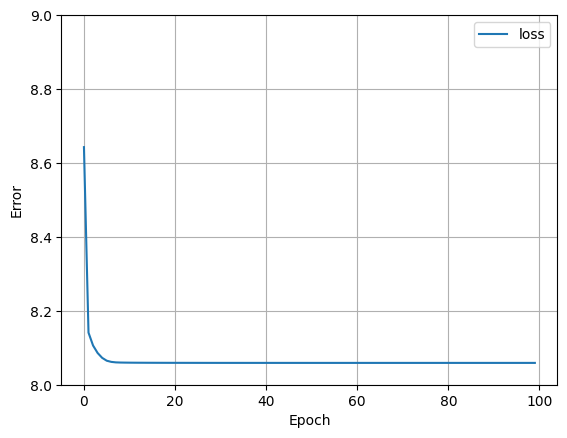

In [51]:
def plot_loss(history,range):
  plt.plot(history.history['loss'], label='loss')
  plt.ylim(range)
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.legend()
  plt.grid(True)

plot_loss(history,[8,9])

We can see the limitations of the simplicity of this model and it can't reduce the loss after the first epochs. Let's see first what is our NN doing here and interpret what the classification layer is doing to determine wether a point in this dataset is labeled as group 0 or group 1.

Taking inspiration on the functions and examples fron Scikit learn website

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classifcation...


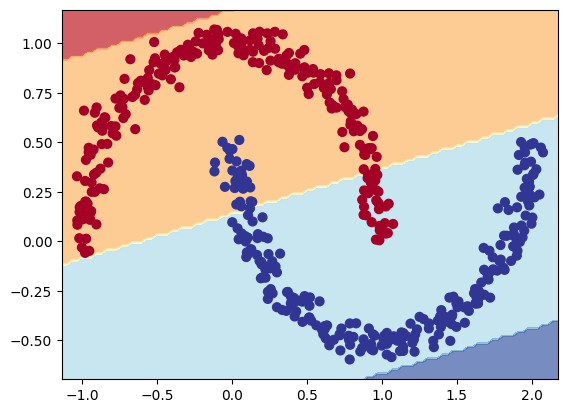

In [75]:
def plot_decision(model,X,y):
  """
  Plots the decision boundary created by a model predicting on X.
  This function has been adapted from two phenomenal resources:
   1. CS231n - https://cs231n.github.io/neural-networks-case-study/
   2. Made with ML basics - https://github.com/GokuMohandas/MadeWithML/blob/main/notebooks/08_Neural_Networks.ipynb
  """
  # Define the axis boundaries of the plot and create a meshgrid
  x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
  y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
  xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                       np.linspace(y_min, y_max, 100))

  # Create X values (we're going to predict on all of these)
  x_in = np.c_[xx.ravel(), yy.ravel()] # stack 2D arrays together: https://numpy.org/devdocs/reference/generated/numpy.c_.html

  # Make predictions using the trained model
  y_pred = model.predict(x_in)

  # Check for multi-class
  if model.output_shape[-1] > 1: # checks the final dimension of the model's output shape, if this is > (greater than) 1, it's multi-class
    print("doing multiclass classification...")
    # We have to reshape our predictions to get them ready for plotting
    y_pred = np.argmax(y_pred, axis=1).reshape(xx.shape)
  else:
    print("doing binary classifcation...")
    y_pred = np.round(np.max(y_pred, axis=1)).reshape(xx.shape)

  # Plot decision boundary
  plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
  plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
  plt.xlim(xx.min(), xx.max())
  plt.ylim(yy.min(), yy.max())
plot_decision(model_1,X,y)

In [76]:
# Basic model 1

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_1 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(3),
    tf.keras.layers.Dense(1)]
)

# 2. Compile the model.

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.SGD(),
                metrics=['accuracy'])

# 3. Fit the model.

history = model_1.fit(X, y, epochs=100, verbose=0)

In [57]:
history_table_1 = build_hist_table(history)
history_table_1.tail()

,accuracy,loss,epoch
95,0.878,0.231731,95
96,0.878,0.231752,96
97,0.878,0.231730,97
98,0.878,0.231751,98
99,0.878,0.231730,99


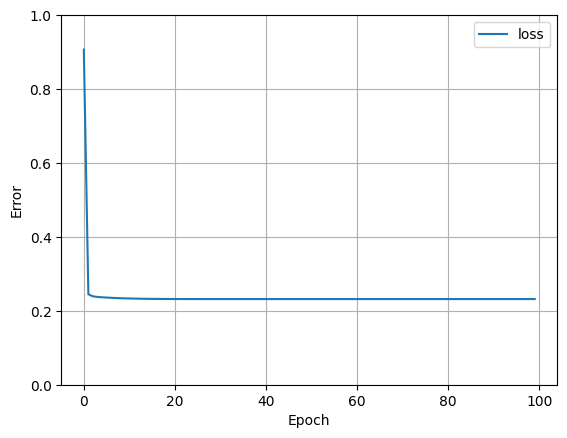

In [60]:
plot_loss(history,[0,1])

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
doing binary classifcation...


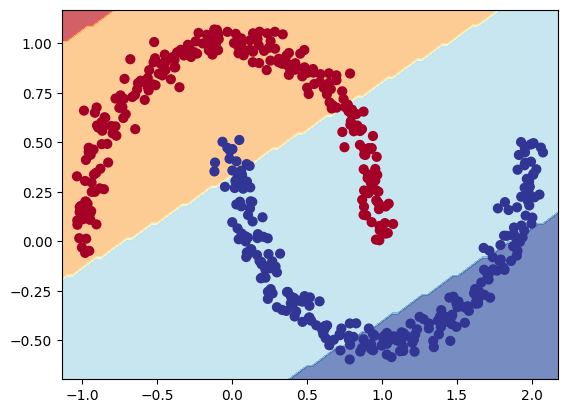

In [77]:
plot_decision(model_1,X,y)

In [98]:
# Basic model 1

# Select random seed

tf.random.set_seed(10)

# 1. Create the model.

model_1 = tf.keras.Sequential(
    [ tf.keras.layers.Dense(4,activation=tf.keras.activations.relu),
     tf.keras.layers.Dense(4,activation=tf.keras.activations.relu),
    tf.keras.layers.Dense(1,activation=tf.keras.activations.sigmoid)]
)

# 2. Compile the model.

model_1.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

# 3. Fit the model.

history = model_1.fit(X, y, epochs=100, verbose=0)

In [99]:
history_table_1 = build_hist_table(history)
history_table_1.tail()

,accuracy,loss,epoch
95,0.906,0.270966,95
96,0.906,0.270160,96
97,0.906,0.269380,97
98,0.906,0.268606,98
99,0.906,0.267842,99


313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
doing binary classifcation...


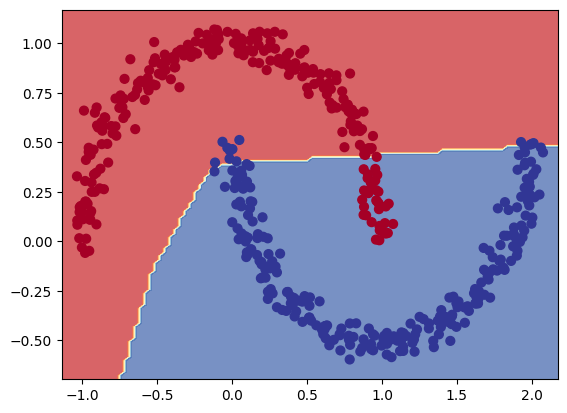

In [100]:
plot_decision(model_1,X,y)